In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import time
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import glob
import datetime
import scipy
from scipy.sparse import diags
import arviz as az

from scipy.linalg import solve_banded

import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error

In [2]:
def get_month_start_days():
    return pd.date_range('2023-01-01', '2023-12-31', freq='MS').dayofyear.tolist()

def get_month_start_labels():
    return pd.date_range('2023-01-01', '2023-12-31', freq='MS').strftime('%m-%d').tolist()


In [3]:
def get_95CI(signal, alpha = 5.0):
    signal.index = pd.to_numeric(signal.index)

    CI95_lower = []
    CI95_upper = []

    for timestep in range(signal.shape[0]):

        # Gather the samples at time t:
        drawn_at_time_t = signal.loc[timestep].values

        # Computes the lower bound:
        lower_p = alpha / 2.0
        
        # Retrieves the observation at the lower percentile index:
        lower = np.percentile(drawn_at_time_t, lower_p)

        # Computes the upper bound:
        upper_p = (100 - alpha) + (alpha / 2.0)
        
        # Retrieves the observation at the upper percentile index:
        upper = np.percentile(drawn_at_time_t, upper_p)

        CI95_lower.append(lower)
        CI95_upper.append(upper)
        
    return CI95_lower, CI95_upper

In [4]:
def model_3_estimation(full_obs_matrix, obs_matrix, parameter_index, components):
    variables = ['NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']

    new_QIj_vect = []
    valeur_theorique_param = QIj_vect[parameter_index]
    
    for i in range(7):
        factor = (full_obs_matrix[:,i] / full_obs_matrix[:,parameter_index]).mean()
        new_QIj_vect.append(factor * valeur_theorique_param)
    
    new_QIj_vect = np.array(new_QIj_vect)
    new_QIj_vect
    
    print("==============")
    print(new_QIj_vect)
    print(parameter_index)
    print("==============")

    nb_components = len(components)
    
    sub_obs_matrix = obs_matrix.copy()
    sub_new_QIj_vect = new_QIj_vect.copy()
    sub_obs_matrix = sub_obs_matrix[:, components]
    sub_new_QIj_vect = sub_new_QIj_vect[components]

    print("---------")
    print(components)
    print(np.array(variables)[components])
    print(sub_obs_matrix.shape, sub_new_QIj_vect.shape)
    print("---------")

    ####
    this_pointwise_Nt_hat = []
    
    for t in range(sub_obs_matrix.shape[0]):
    
        def params_estimation(theta):
            this_y = sub_obs_matrix[t]
            this_alpha = sub_new_QIj_vect
            this_beta = np.zeros(sub_obs_matrix.shape[1])
        
            this_alpha_theta = this_alpha * theta[0]

            for this_index in range(nb_components):     
                if this_index!=parameter_index:
                    this_beta[this_index] = theta[this_index+1]

            return np.linalg.norm(this_y - this_alpha_theta - this_beta)
    
    
        res = scipy.optimize.minimize(params_estimation, x0=np.ones(sub_obs_matrix.shape[1]))
        this_pointwise_Nt_hat.append(res['x'][0])

    return this_pointwise_Nt_hat

In [5]:
filepath = "../data/samples_quantifications.xlsx"

def get_raw_data(wwtp):
    if wwtp == 'MAV':
        raw_data = pd.read_excel(filepath, sheet_name='MAV')
        raw_data = raw_data.loc[1:]
        raw_data = raw_data.rename(columns={'MAV':'dateStart',
                                           'Débit Total station':'plantVolume'})
    
        raw_data.dateStart = pd.to_datetime(raw_data.dateStart)
        raw_data.plantVolume = pd.to_numeric(raw_data.plantVolume)
        raw_data.NH4 = pd.to_numeric(raw_data.NH4)
        raw_data.NTK = pd.to_numeric(raw_data.NTK)
        raw_data.DCO = pd.to_numeric(raw_data.DCO)
        raw_data.DBO = pd.to_numeric(raw_data.DBO)
        raw_data.MES = pd.to_numeric(raw_data.MES)
        raw_data.NGL = pd.to_numeric(raw_data.NGL)
        raw_data.PT = pd.to_numeric(raw_data.PT)
        
        raw_data['month'] = raw_data.dateStart.dt.month
        raw_data['year'] = raw_data.dateStart.dt.year
        raw_data['day'] = raw_data.dateStart.dt.dayofyear
    
    elif wwtp == 'SEC':
        raw_data = pd.read_excel(filepath, sheet_name='SEC')
        raw_data = raw_data.loc[1:]
        raw_data = raw_data.rename(columns={'SEC':'dateStart',
                                           'Débit Total station':'plantVolume'})
    
        raw_data.dateStart = pd.to_datetime(raw_data.dateStart)
        raw_data.plantVolume = pd.to_numeric(raw_data.plantVolume)
        raw_data.NH4 = pd.to_numeric(raw_data.NH4)
        raw_data.NTK = pd.to_numeric(raw_data.NTK)
        raw_data.DCO = pd.to_numeric(raw_data.DCO)
        raw_data.DCO = pd.to_numeric(raw_data.DBO)
        raw_data.MES = pd.to_numeric(raw_data.MES)
        raw_data.NGL = pd.to_numeric(raw_data.NGL)
        raw_data.PT = pd.to_numeric(raw_data.PT)
        
        raw_data['month'] = raw_data.dateStart.dt.month
        raw_data['year'] = raw_data.dateStart.dt.year
        raw_data['day'] = raw_data.dateStart.dt.dayofyear
    
    elif wwtp == 'SEV':
        raw_data = pd.read_excel(filepath, sheet_name='SEV')
        raw_data = raw_data.loc[1:]
        raw_data = raw_data.rename(columns={'SEV':'dateStart',
                                           'Débit Total station':'plantVolume'})
    
        raw_data.dateStart = pd.to_datetime(raw_data.dateStart)
        raw_data.plantVolume = pd.to_numeric(raw_data.plantVolume)
        raw_data.NH4 = pd.to_numeric(raw_data.NH4)
        raw_data.NTK = pd.to_numeric(raw_data.NTK)
        raw_data.DCO = pd.to_numeric(raw_data.DCO)
        raw_data.DBO = pd.to_numeric(raw_data.DBO)
        raw_data.MES = pd.to_numeric(raw_data.MES)
        raw_data.NGL = pd.to_numeric(raw_data.NGL)
        raw_data.PT = pd.to_numeric(raw_data.PT)
        
        raw_data['month'] = raw_data.dateStart.dt.month
        raw_data['year'] = raw_data.dateStart.dt.year
        raw_data['day'] = raw_data.dateStart.dt.dayofyear

    return raw_data

In [6]:
def get_obs_matrix(wwtp):
    
    raw_data = get_raw_data(wwtp)
    raw_data = raw_data.loc[raw_data.year>=2020].copy()
    raw_data.reset_index(inplace=True, drop=True)
    files = glob.glob("../outputs/files/pop_estimation_" + wwtp +  "_hierarchical_manuscript/*.csv")

    smoothed_wwtp_dict = {}
    smoothed_wwtp_dict_CIL = {}
    smoothed_wwtp_dict_CIU = {}
    
    # MAV
    for indicator in ['NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']:
        this_file = indicator + '.csv'
    
        for this_path in files:
            if this_file in this_path:
                this_traces = pd.read_csv(this_path, sep=';')
                this_mean_trace = this_traces.muX.values
                this_CIL, this_CIU = this_traces.ICL.values, this_traces.ICU.values
                smoothed_wwtp_dict[indicator] = this_mean_trace
                smoothed_wwtp_dict_CIL[indicator] = this_CIL
                smoothed_wwtp_dict_CIU[indicator] = this_CIU
                
    obs_matrix_CIL = np.array(list(smoothed_wwtp_dict_CIL.values())).T
    obs_matrix_CIL = 10**(obs_matrix_CIL)
    obs_matrix_CIU = np.array(list(smoothed_wwtp_dict_CIU.values())).T
    obs_matrix_CIU = 10**(obs_matrix_CIU)
    
    obs_matrix = np.array(list(smoothed_wwtp_dict.values())).T
    obs_matrix = 10**(obs_matrix)

    return raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU

In [7]:
def plot_indicators(raw_data, obs_matrix, QIj_vect):

    colors = ['royalblue', 'green', 'orange', 'gold', 'gray', 'teal', 'fuchsia',
             'purple', 'lime', 'black']
    
    keys_list = ['A', 'B', 'C', 
                 'D', 'E', 'F',
                 'G']
    
    indicators_list = ['NH4+', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']
    
    with plt.style.context(['science', 'notebook', 'grid']):
            
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        #figsize = (96, 60)
        figsize = (32, 20)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            ABC
            DEF
            GHI
            """
        )
    
    
        for index, key in enumerate(keys_list):
    
            ax_dict[key].plot(raw_data.dateStart.values, obs_matrix[:,index] / obs_matrix[:,0] ,
                                 label='Population estimée', color=colors[index],
                                 linewidth=5)
    
            ax_dict[key].plot(raw_data.dateStart.values, (np.ones(obs_matrix.shape[0]) * QIj_vect[index]) / QIj_vect[0],
                                 label='Theoretical ratio', color='red',
                                 linewidth=5)
    
            
    
            ax_dict[key].set_title(indicators_list[index], size=TITLE_SIZE)
            ax_dict[key].set_ylabel("Ratio par rapport à $NH_4^+$", size=LABEL_SIZE)
            ax_dict[key].set_xlabel("Sampling date", size=LABEL_SIZE)
            ax_dict[key].tick_params(axis='x', labelsize=TICK_SIZE)
            ax_dict[key].tick_params(axis='y', labelsize=TICK_SIZE)
            ax_dict[key].tick_params(axis='x', rotation=45)
    
    
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
        plt.show()

In [8]:
def get_new_QIj_vect_and_CIs(obs_matrix):
    new_QIj_vect = []
    new_QIj_vect_CIL = []
    new_QIj_vect_CIU = []
    valeur_theorique_NGL = 12.6
    
    for i in range(7):
        factor = (obs_matrix[:,i] / obs_matrix[:,4]).mean()
        new_QIj_vect.append(factor * valeur_theorique_NGL)
    
        lower_factor = np.percentile(obs_matrix[:,i] / obs_matrix[:,4], 2.5)
        upper_factor = np.percentile(obs_matrix[:,i] / obs_matrix[:,4], 97.5)
    
        new_QIj_vect_CIL.append(lower_factor * valeur_theorique_NGL)
        new_QIj_vect_CIU.append(upper_factor * valeur_theorique_NGL)
    
    new_QIj_vect = np.array(new_QIj_vect)
    new_QIj_vect_CIL = np.array(new_QIj_vect_CIL)
    new_QIj_vect_CIU = np.array(new_QIj_vect_CIU)
    
    print(new_QIj_vect_CIL)
    print(new_QIj_vect)
    print(new_QIj_vect_CIU)

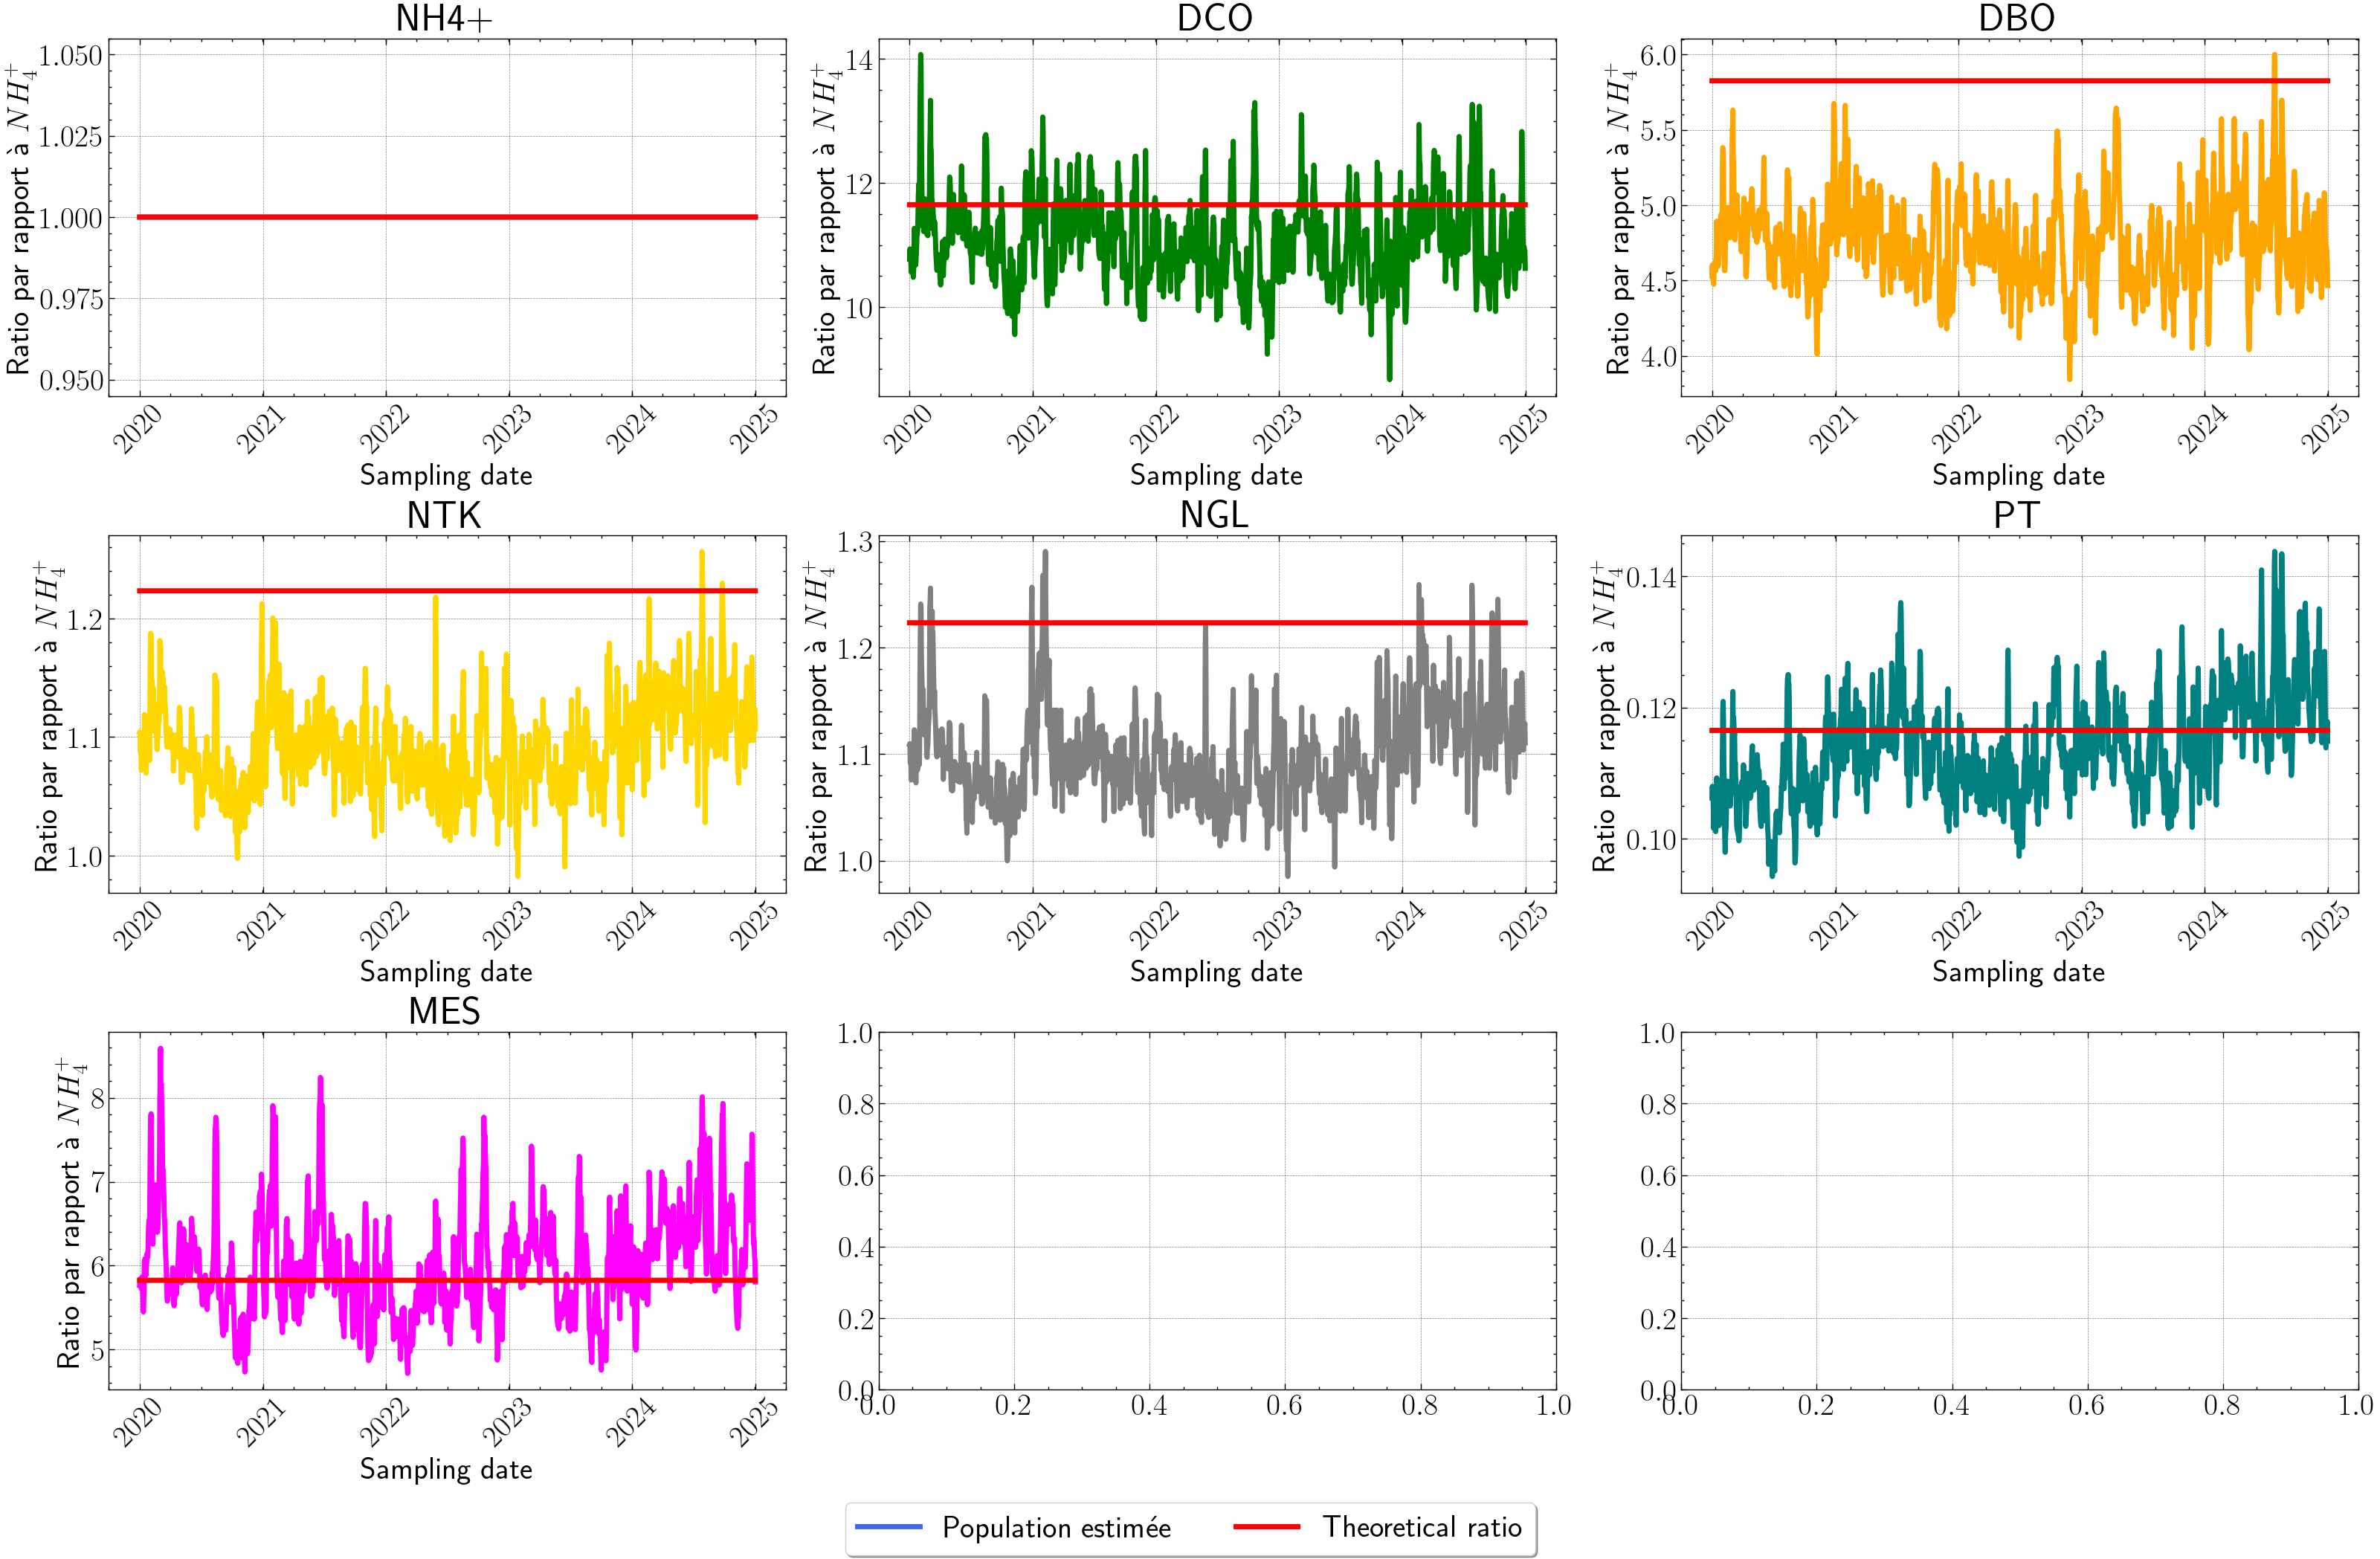

[ 10.44713473 115.64446941  49.75369938  12.02515922  12.6
   1.17553537  59.43282811]
[ 11.48858281 126.83481394  54.47919397  12.51497362  12.6
   1.30342301  68.85574814]
[ 12.19069635 138.86914882  59.38262517  12.58528959  12.6
   1.44068654  81.06239303]
[ 11.55521994 128.57250978  55.13338462  12.49602278  12.6
   1.24249963  69.07462434]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.55521994 128.57250978  55.13338462  12.49602278  12.6
   1.24249963  69.07462434]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.55521994 128.57250978  55.13338462  12.49602278  12.6
   1.24249963  69.07462434]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/files/SEV_NtHat_hierarchical_1710_QIJ_2020/model_3_4_NH4-DCO-DBO-NTK-NGL.csv'

In [9]:
wwtp = 'SEV'
raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU = get_obs_matrix(wwtp)

'NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES'
QIj_vect = np.array([10.3, 120, 60, 12.6, 12.6, 1.2, 60])

plot_indicators(raw_data, obs_matrix, QIj_vect)
get_new_QIj_vect_and_CIs(obs_matrix)

raw_data = raw_data.loc[:365]

k = 4
components = [0, 1, 2, 3, 4]

this_NT_hat = model_3_estimation(obs_matrix[:366], obs_matrix[:366], k, components)
this_NT_hat_CIL = model_3_estimation(obs_matrix[:366], obs_matrix_CIL[:366], k, components)
this_NT_hat_CIU = model_3_estimation(obs_matrix[:366], obs_matrix_CIU[:366], k, components)

test = pd.read_csv('../outputs/files/' + wwtp + '_NtHat_hierarchical_1710_QIJ_2020/model_3_4_NH4-DCO-DBO-NTK-NGL.csv', sep=";")
print('Is everything ok? ' + str(np.allclose(this_NT_hat, test.Nt_hat.values)))

In [11]:
get_new_QIj_vect_and_CIs(obs_matrix[:366])

[ 10.27095568 119.68044332  51.03128376  11.86743346  12.6
   1.12887066  60.07216888]
[ 11.55521994 128.57250978  55.13338462  12.49602278  12.6
   1.24249963  69.07462434]
[ 12.17817324 139.24896774  58.40267008  12.58205132  12.6
   1.35392706  82.40019862]


In [12]:
obs_matrix = obs_matrix[:366]

new_QIj_vect = []
new_QIj_vect_CIL = []
new_QIj_vect_CIU = []
valeur_theorique_NGL = 12.6

for i in range(7):
    factor = (obs_matrix[:,i] / obs_matrix[:,4]).mean()
    new_QIj_vect.append(factor * valeur_theorique_NGL)

    lower_factor = np.percentile(obs_matrix[:,i] / obs_matrix[:,4], 2.5)
    upper_factor = np.percentile(obs_matrix[:,i] / obs_matrix[:,4], 97.5)

    new_QIj_vect_CIL.append(lower_factor * valeur_theorique_NGL)
    new_QIj_vect_CIU.append(upper_factor * valeur_theorique_NGL)

new_QIj_vect = np.array(new_QIj_vect)
new_QIj_vect_CIL = np.array(new_QIj_vect_CIL)
new_QIj_vect_CIU = np.array(new_QIj_vect_CIU)

In [13]:
new_QIj_vect

array([ 11.55521994, 128.57250978,  55.13338462,  12.49602278,
        12.6       ,   1.24249963,  69.07462434])

In [29]:
obs_matrix

array([[3.13741793e+07, 3.37926621e+08, 1.42146484e+08, ...,
        3.47939887e+07, 3.33287973e+06, 1.80903879e+08],
       [3.08326299e+07, 3.37243267e+08, 1.41890717e+08, ...,
        3.42182067e+07, 3.32964138e+06, 1.80078696e+08],
       [3.11615149e+07, 3.36191558e+08, 1.40600425e+08, ...,
        3.40257836e+07, 3.31729227e+06, 1.79814049e+08],
       ...,
       [2.69540204e+07, 3.34291013e+08, 1.51432413e+08, ...,
        3.38741743e+07, 3.07228195e+06, 1.86362550e+08],
       [2.72642428e+07, 3.30513130e+08, 1.49015788e+08, ...,
        3.28186684e+07, 3.07360394e+06, 1.81790560e+08],
       [2.79648971e+07, 3.28796534e+08, 1.47899388e+08, ...,
        3.24208774e+07, 3.07453324e+06, 1.80216338e+08]])

In [28]:
D = 366
index = 6

res = 0
for t in range(D):
    res += obs_matrix[t,index] / obs_matrix[t,4] 

res /= D
res *= valeur_theorique_NGL
res

69.07462433503613

In [12]:
raw_data['Nt_hat_4'] = this_NT_hat
raw_data['Nt_hat_4_CIL'] = this_NT_hat_CIL
raw_data['Nt_hat_4_CIU'] = this_NT_hat_CIU
raw_data.to_csv('../outputs/files/ww_estimator/df_' + wwtp + '_final.csv', index=False, sep=";")

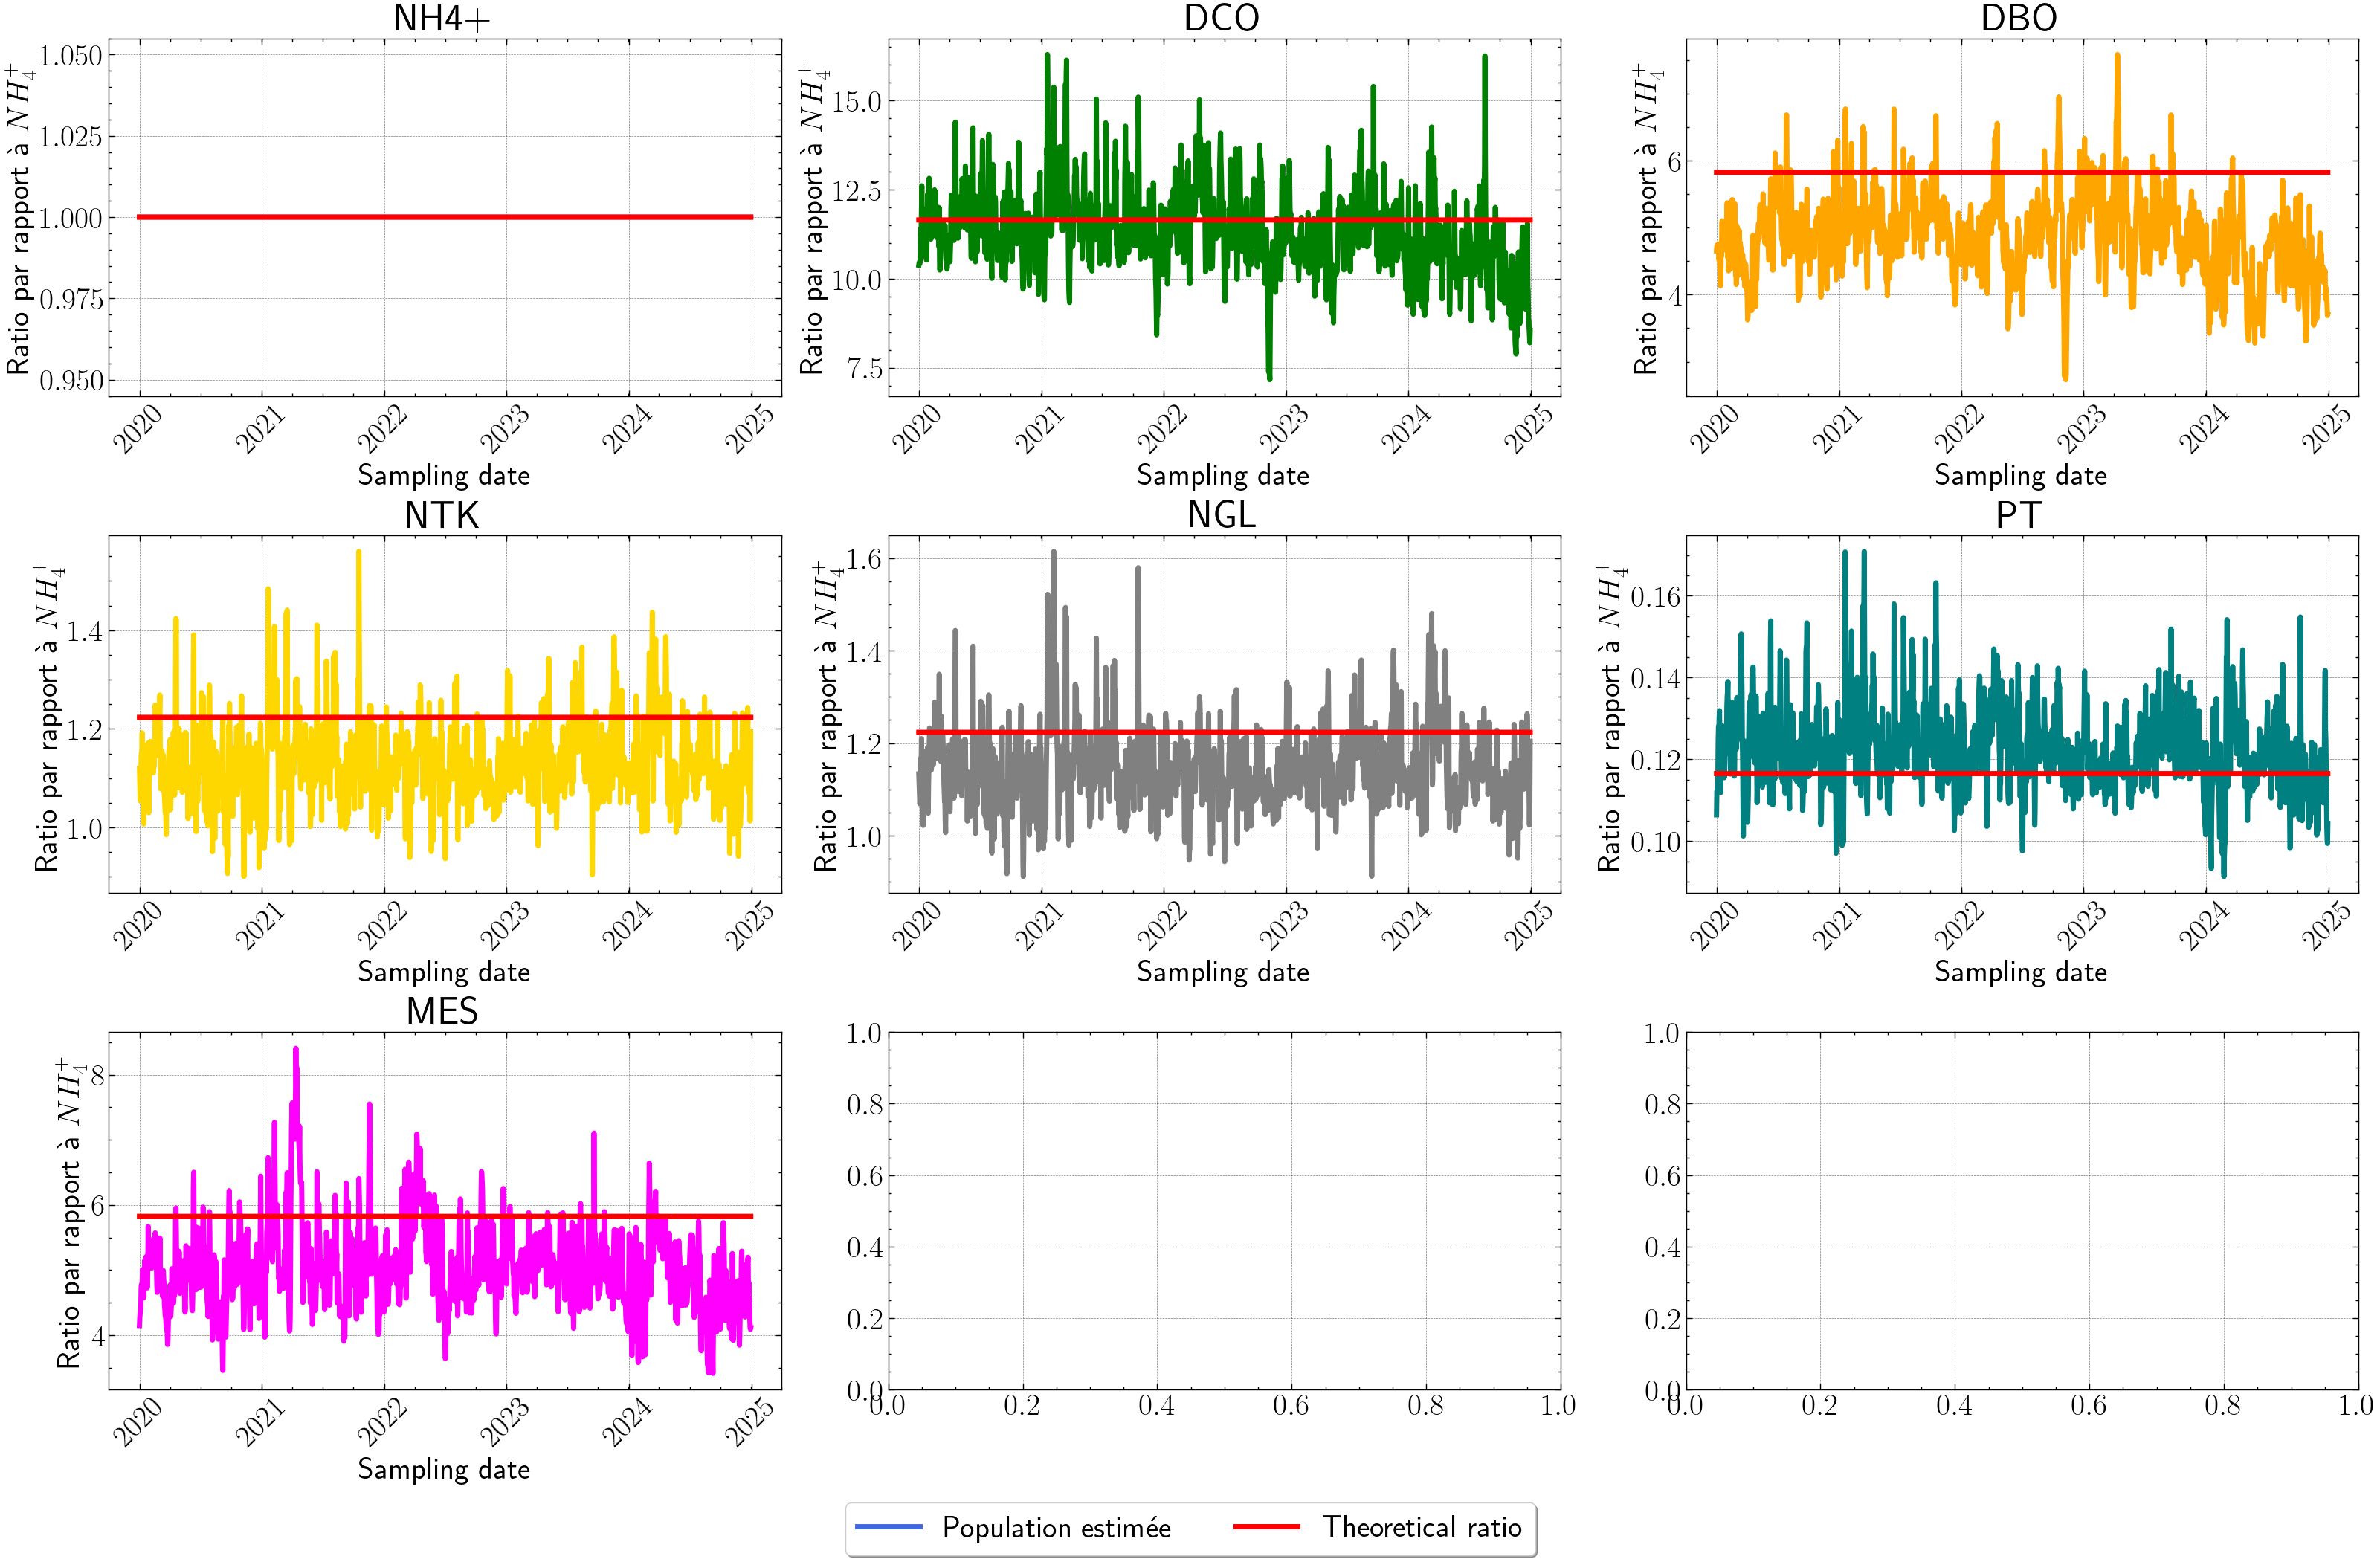

[  9.34793356 103.94572729  41.97226526  11.97632322  12.6
   1.19538407  45.47478244]
[ 11.06280825 124.52190484  53.68159731  12.42761914  12.6
   1.34719358  55.65214593]
[ 12.53262741 145.32173299  65.88808598  12.52030985  12.6
   1.52088684  72.02226604]
[ 11.15410589 128.15775896  53.93984364  12.37514038  12.6
   1.36484531  54.54832526]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.15410589 128.15775896  53.93984364  12.37514038  12.6
   1.36484531  54.54832526]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.15410589 128.15775896  53.93984364  12.37514038  12.6
   1.36484531  54.54832526]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
Is everything ok? True


In [11]:
wwtp = 'MAV'
raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU = get_obs_matrix(wwtp)

'NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES'
QIj_vect = np.array([10.3, 120, 60, 12.6, 12.6, 1.2, 60])

plot_indicators(raw_data, obs_matrix, QIj_vect)
get_new_QIj_vect_and_CIs(obs_matrix)

raw_data = raw_data.loc[:365]

k = 4
components = [0, 1, 2, 3, 4]

this_NT_hat = model_3_estimation(obs_matrix[:366], obs_matrix[:366], k, components)
this_NT_hat_CIL = model_3_estimation(obs_matrix[:366], obs_matrix_CIL[:366], k, components)
this_NT_hat_CIU = model_3_estimation(obs_matrix[:366], obs_matrix_CIU[:366], k, components)

test = pd.read_csv('../outputs/files/' + wwtp + '_NtHat_hierarchical_1710_QIJ_2020/model_3_4_NH4-DCO-DBO-NTK-NGL.csv', sep=";")
print('Is everything ok? ' + str(np.allclose(this_NT_hat, test.Nt_hat.values)))

In [12]:
get_new_QIj_vect_and_CIs(obs_matrix[:366])

[  9.83454822 113.56799196  42.74698909  11.7619332   12.6
   1.23248826  46.19328346]
[ 11.15410589 128.15775896  53.93984364  12.37514038  12.6
   1.36484531  54.54832526]
[ 12.87914668 143.68389931  65.64707779  12.46787159  12.6
   1.55036269  63.06886788]


In [10]:
obs_matrix[:366]

array([[3.13741793e+07, 3.37926621e+08, 1.42146484e+08, ...,
        3.47939887e+07, 3.33287973e+06, 1.80903879e+08],
       [3.08326299e+07, 3.37243267e+08, 1.41890717e+08, ...,
        3.42182067e+07, 3.32964138e+06, 1.80078696e+08],
       [3.11615149e+07, 3.36191558e+08, 1.40600425e+08, ...,
        3.40257836e+07, 3.31729227e+06, 1.79814049e+08],
       ...,
       [2.69540204e+07, 3.34291013e+08, 1.51432413e+08, ...,
        3.38741743e+07, 3.07228195e+06, 1.86362550e+08],
       [2.72642428e+07, 3.30513130e+08, 1.49015788e+08, ...,
        3.28186684e+07, 3.07360394e+06, 1.81790560e+08],
       [2.79648971e+07, 3.28796534e+08, 1.47899388e+08, ...,
        3.24208774e+07, 3.07453324e+06, 1.80216338e+08]])

In [14]:
raw_data['Nt_hat_4'] = this_NT_hat
raw_data['Nt_hat_4_CIL'] = this_NT_hat_CIL
raw_data['Nt_hat_4_CIU'] = this_NT_hat_CIU
raw_data.to_csv('../outputs/files/ww_estimator/df_' + wwtp + '_final.csv', index=False, sep=";")

In [20]:
raw_data.loc[(raw_data.dateStart>='2021-01-01')&(raw_data.dateStart<='2024-12-25')]

dateStart  plantVolume    DBO    DCO      MES    NGL    NH4      NH4.1  \
366  2021-01-01    190307.08  102.4  102.4  142.000  38.63  32.76        NaN   
367  2021-01-02    171628.51  110.4  110.4  141.667  40.59  33.54        NaN   
368  2021-01-03    224764.19  130.3  130.3  218.333  46.24  35.33        NaN   
369  2021-01-04    269655.69  163.3  163.3  193.333  45.91  36.76        NaN   
370  2021-01-05    274966.16  134.8  134.8  210.667  47.36  39.34        NaN   
...         ...          ...    ...    ...      ...    ...    ...        ...   
1816 2024-12-21    179594.00    127  127.0  248.000  35.62  33.00  25.666667   
1817 2024-12-22    225766.00    132  132.0  140.000  24.08  18.80  14.622222   
1818 2024-12-23    165910.00    196  196.0  156.000  39.77  34.70  26.988889   
1819 2024-12-24    166595.00    182  182.0  145.000  38.17  33.60  26.133333   
1820 2024-12-25    172529.00    176  176.0  153.000  39.74  37.60  29.244444   

          NTK      PT Vérification Commentaires éventuels Pluviométrie  \
366   37.7491  3.2891          NaN                    NaN         0.43   
367   38.8774  3.6748          NaN                    NaN            0   
368   44.4362  4.2482          NaN                    NaN         0.16   
369   43.3729  4.2652          NaN                    NaN         0.08   
370   44.7618  4.5727          NaN                    NaN         0.07   
...       ...     ...          ...                    ...          ...   
1816  35.0000  3.9000          NaN                    NaN         14.7   
1817  21.5000  2.2000     Check me        Valeur vérifiée         7.68   
1818  37.1000  3.6000          NaN                    NaN            1   
1819  36.8000  3.5000          NaN                    NaN         0.12   
1820  38.5000  3.6000          NaN                    NaN            0   

     Population théorique raccordée Incidents / routage  \
366                             NaN                 NaN   
367                             NaN                 NaN   
368                             NaN                 NaN   
369                             NaN                 NaN   
370                             NaN                 NaN   
...                             ...                 ...   
1816                            NaN                 NaN   
1817                            NaN                 NaN   
1818                            NaN                 NaN   
1819                            NaN                 NaN   
1820                            NaN                 NaN   

     Commentaires éventuels.1  month  year  day  
366                       NaN      1  2021    1  
367                       NaN      1  2021    2  
368                       NaN      1  2021    3  
369                       NaN      1  2021    4  
370                       NaN      1  2021    5  
...                       ...    ...   ...  ...  
1816                      NaN     12  2024  356  
1817                      NaN     12  2024  357  
1818                      NaN     12  2024  358  
1819                      NaN     12  2024  359  
1820                      NaN     12  2024  360  

[1455 rows x 19 columns]

In [13]:
wwtp = 'SEC'
raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU = get_obs_matrix(wwtp)
raw_data = raw_data.loc[(raw_data.dateStart>='2021-01-01')&(raw_data.dateStart<='2024-12-25')]
raw_data.reset_index(inplace=True, drop=True)
raw_data

dateStart  plantVolume    DBO    DCO      MES    NGL    NH4      NH4.1  \
0    2021-01-01    190307.08  102.4  102.4  142.000  38.63  32.76        NaN   
1    2021-01-02    171628.51  110.4  110.4  141.667  40.59  33.54        NaN   
2    2021-01-03    224764.19  130.3  130.3  218.333  46.24  35.33        NaN   
3    2021-01-04    269655.69  163.3  163.3  193.333  45.91  36.76        NaN   
4    2021-01-05    274966.16  134.8  134.8  210.667  47.36  39.34        NaN   
...         ...          ...    ...    ...      ...    ...    ...        ...   
1450 2024-12-21    179594.00    127  127.0  248.000  35.62  33.00  25.666667   
1451 2024-12-22    225766.00    132  132.0  140.000  24.08  18.80  14.622222   
1452 2024-12-23    165910.00    196  196.0  156.000  39.77  34.70  26.988889   
1453 2024-12-24    166595.00    182  182.0  145.000  38.17  33.60  26.133333   
1454 2024-12-25    172529.00    176  176.0  153.000  39.74  37.60  29.244444   

          NTK      PT Vérification Commentaires éventuels Pluviométrie  \
0     37.7491  3.2891          NaN                    NaN         0.43   
1     38.8774  3.6748          NaN                    NaN            0   
2     44.4362  4.2482          NaN                    NaN         0.16   
3     43.3729  4.2652          NaN                    NaN         0.08   
4     44.7618  4.5727          NaN                    NaN         0.07   
...       ...     ...          ...                    ...          ...   
1450  35.0000  3.9000          NaN                    NaN         14.7   
1451  21.5000  2.2000     Check me        Valeur vérifiée         7.68   
1452  37.1000  3.6000          NaN                    NaN            1   
1453  36.8000  3.5000          NaN                    NaN         0.12   
1454  38.5000  3.6000          NaN                    NaN            0   

     Population théorique raccordée Incidents / routage  \
0                               NaN                 NaN   
1                               NaN                 NaN   
2                               NaN                 NaN   
3                               NaN                 NaN   
4                               NaN                 NaN   
...                             ...                 ...   
1450                            NaN                 NaN   
1451                            NaN                 NaN   
1452                            NaN                 NaN   
1453                            NaN                 NaN   
1454                            NaN                 NaN   

     Commentaires éventuels.1  month  year  day  
0                         NaN      1  2021    1  
1                         NaN      1  2021    2  
2                         NaN      1  2021    3  
3                         NaN      1  2021    4  
4                         NaN      1  2021    5  
...                       ...    ...   ...  ...  
1450                      NaN     12  2024  356  
1451                      NaN     12  2024  357  
1452                      NaN     12  2024  358  
1453                      NaN     12  2024  359  
1454                      NaN     12  2024  360  

[1455 rows x 19 columns]

In [14]:
years = [2021, 2022, 2023, 2024]
NT_hat_list, NT_hat_CIL_list, NT_hat_CIU_list = [], [], []

for year in years[:1]:
    those_indexes = raw_data.loc[raw_data.year==year].index.tolist()

In [15]:
obs_matrix[those_indexes].shape

(365, 7)

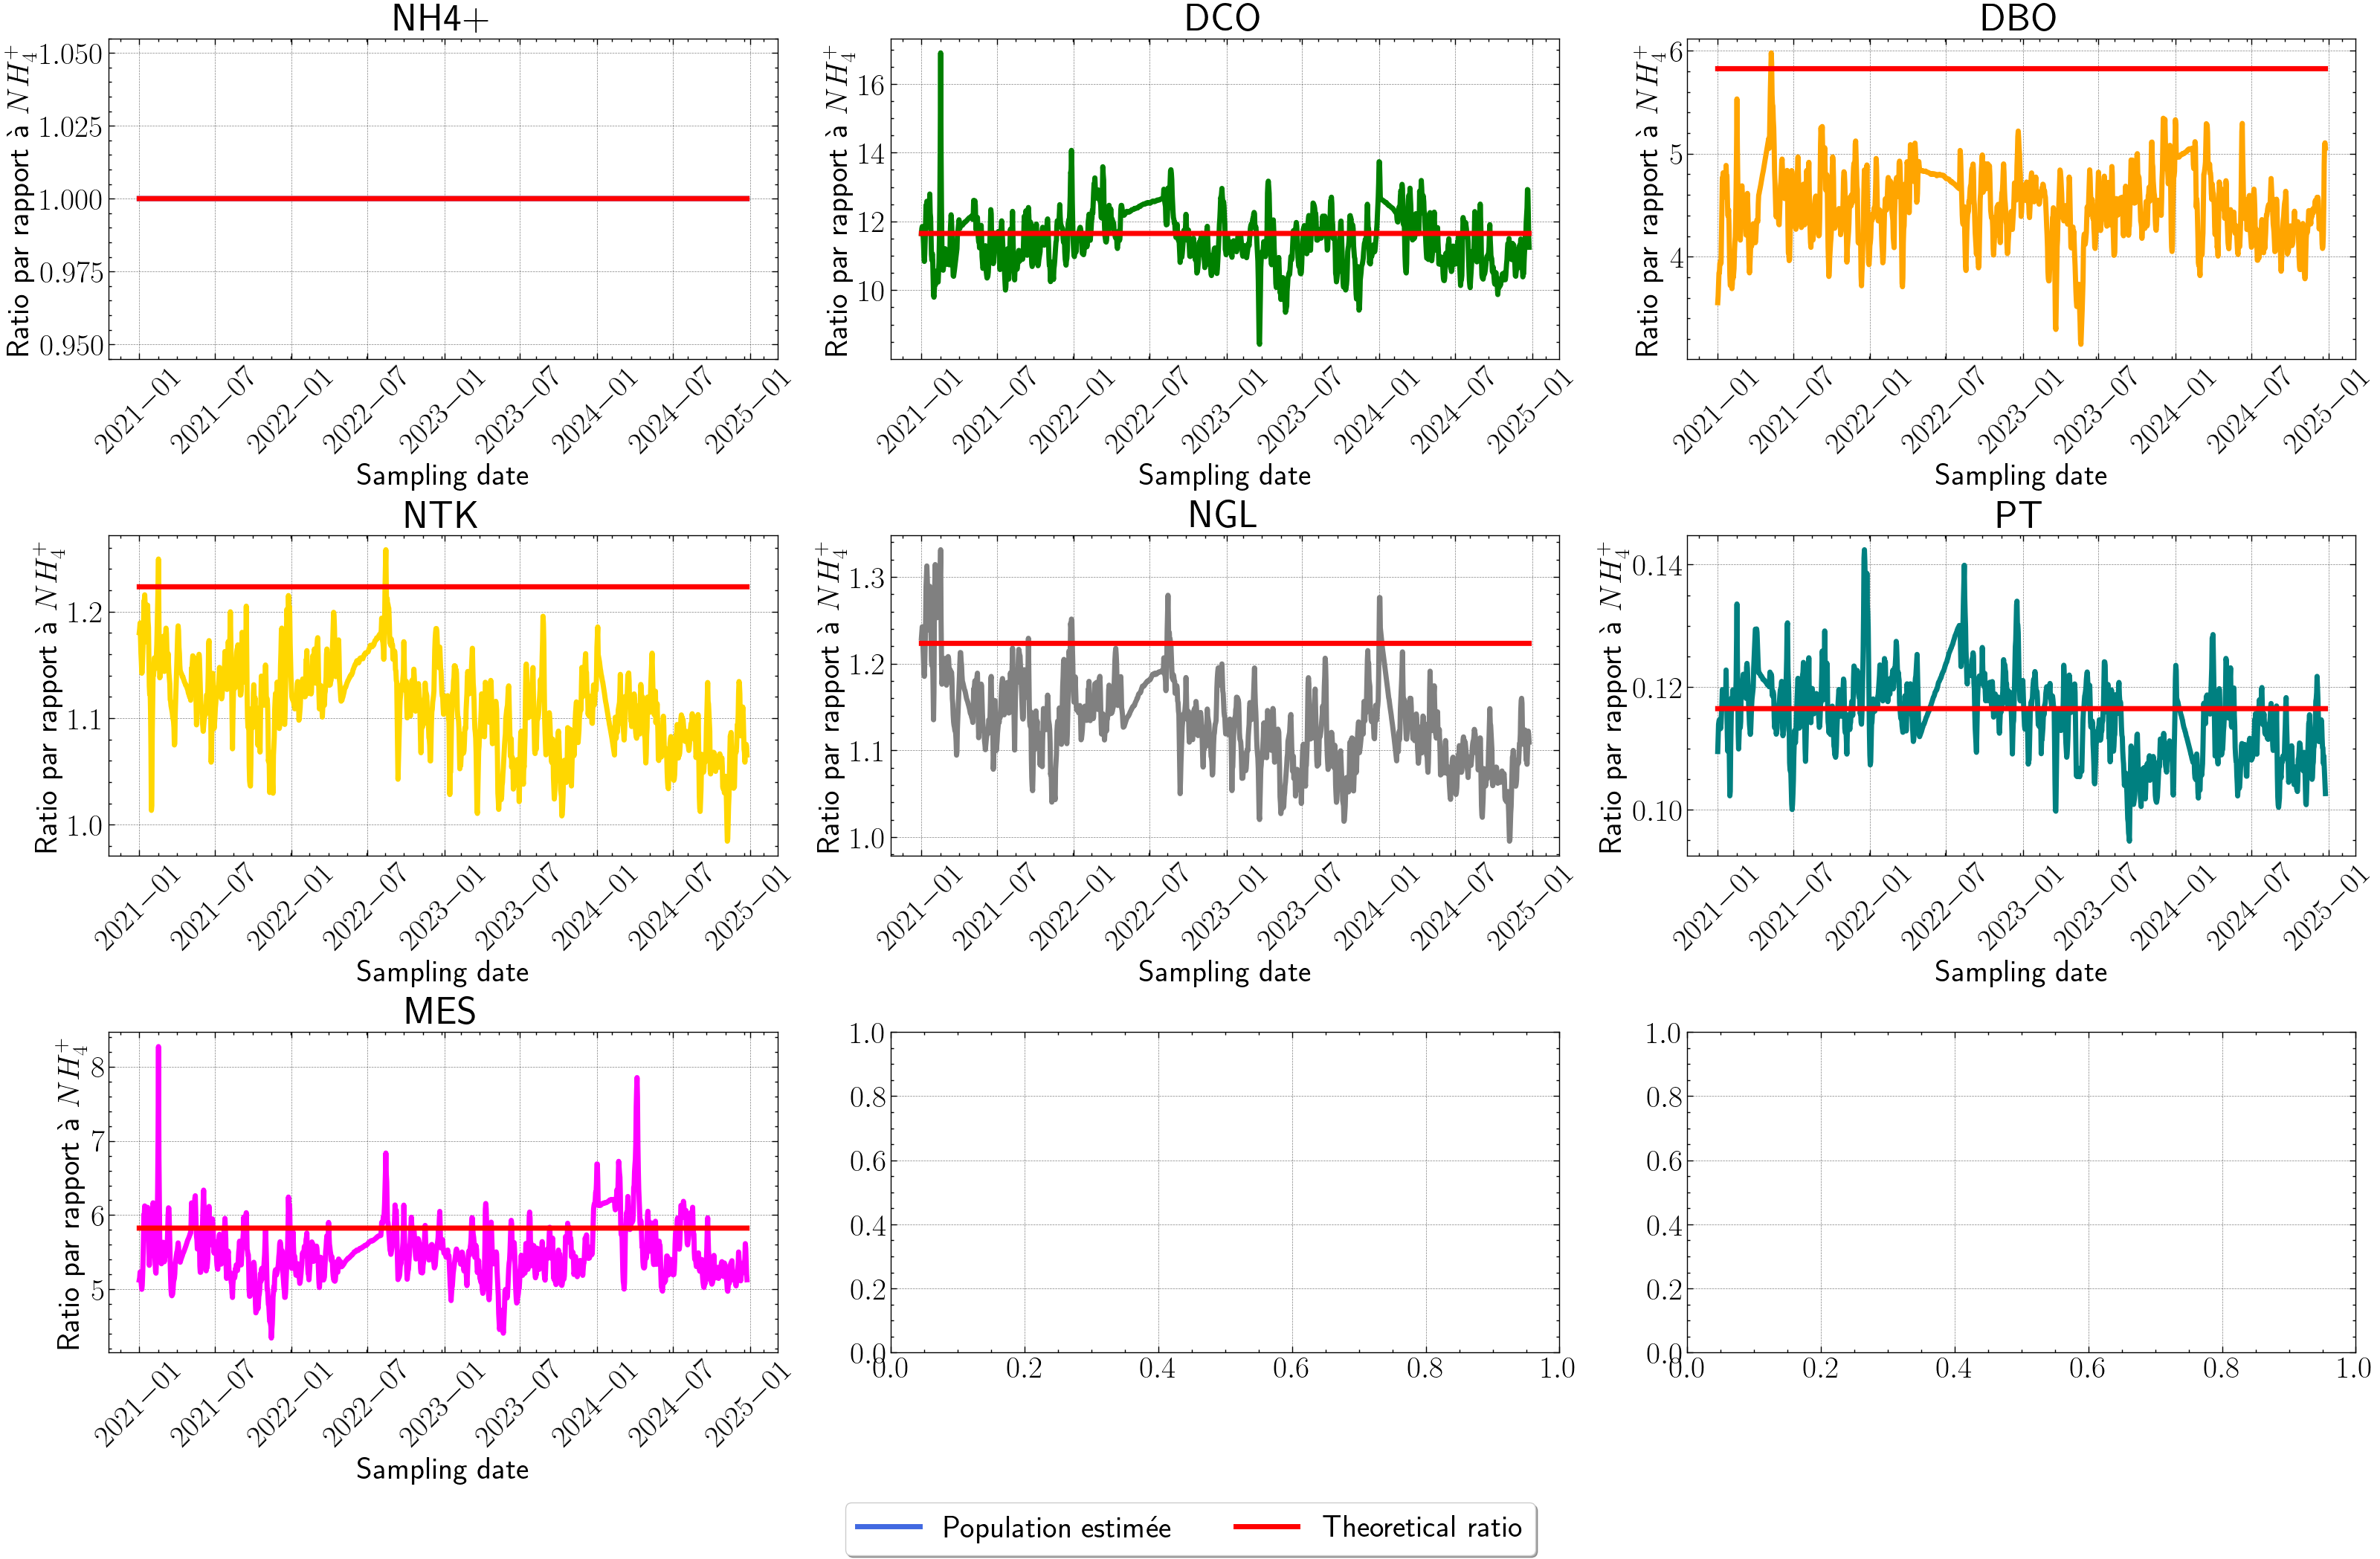

[ 10.14176346 113.19745154  41.50236759  11.83041378  12.6
   1.15347195  54.59979599]
[ 11.14621253 127.88071379  50.06444754  12.37818546  12.6
   1.28386094  61.2312488 ]
[ 12.08638291 140.97221676  57.03804598  12.5084091   12.6
   1.38221135  70.03070529]
[ 10.86398041 123.8696183   48.89026711  12.27665406  12.6
   1.28020143  59.20221595]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(365, 5) (5,)
---------
[ 10.86398041 123.8696183   48.89026711  12.27665406  12.6
   1.28020143  59.20221595]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(365, 5) (5,)
---------
[ 10.86398041 123.8696183   48.89026711  12.27665406  12.6
   1.28020143  59.20221595]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(365, 5) (5,)
---------
[ 10.921161   130.06039866  50.13080293  12.44392007  12.6
   1.3110663   60.28468991]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(365, 5) (5,)
---------
[ 10.921161   130.06039866  50.13080293  12.44392007  1

In [16]:
wwtp = 'SEC'
raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU = get_obs_matrix(wwtp)
raw_data = raw_data.loc[(raw_data.dateStart>='2021-01-01')&(raw_data.dateStart<='2024-12-25')]
raw_data.reset_index(inplace=True, drop=True)

'NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES'
QIj_vect = np.array([10.3, 120, 60, 12.6, 12.6, 1.2, 60])

plot_indicators(raw_data, obs_matrix, QIj_vect)
get_new_QIj_vect_and_CIs(obs_matrix)

# let's start with 2021

k = 4
components = [0, 1, 2, 3, 4]

years = [2021, 2022, 2023, 2024]
NT_hat_list, NT_hat_CIL_list, NT_hat_CIU_list = [], [], []

for year in years:
    those_indexes = raw_data.loc[raw_data.year==year].index.tolist()

    this_NT_hat = model_3_estimation(obs_matrix[those_indexes], obs_matrix[those_indexes], k, components)
    this_NT_hat_CIL = model_3_estimation(obs_matrix[those_indexes], obs_matrix_CIL[those_indexes], k, components)
    this_NT_hat_CIU = model_3_estimation(obs_matrix[those_indexes], obs_matrix_CIU[those_indexes], k, components)

    NT_hat_list.append(this_NT_hat)
    NT_hat_CIL_list.append(this_NT_hat_CIL)
    NT_hat_CIU_list.append(this_NT_hat_CIU)

In [17]:
get_new_QIj_vect_and_CIs(obs_matrix)

[ 10.14176346 113.19745154  41.50236759  11.83041378  12.6
   1.15347195  54.59979599]
[ 11.14621253 127.88071379  50.06444754  12.37818546  12.6
   1.28386094  61.2312488 ]
[ 12.08638291 140.97221676  57.03804598  12.5084091   12.6
   1.38221135  70.03070529]


In [18]:
obs_matrix.shape

(1455, 7)

In [19]:
this_list = [12.4, 12.5, 12.4]
np.array(this_list).mean()

12.433333333333332

In [20]:
this_list = [11.2, 11.6, 11.1]
np.array(this_list).mean()

11.299999999999999

In [21]:
this_list = [1.4, 1.2, 1.3]
np.array(this_list).mean()

1.2999999999999998

In [22]:
this_list = [54.5, 69.1, 61.2]
np.array(this_list).mean()

61.6

In [23]:
this_list = [53.9, 55.1, 50.1]
np.array(this_list).mean()

53.03333333333333

In [24]:
this_list = [128.2, 128.6, 127.9]
np.array(this_list).mean()

128.23333333333332

In [25]:
def ape(target, pred):
    num = pred - target
    return np.abs(num / target)

In [26]:
ape(120, 128.2)

0.06833333333333323

In [27]:
concat_NT_hat = np.array([])

for el in NT_hat_list:
    el = np.array(el)
    concat_NT_hat = np.hstack((concat_NT_hat, el))

concat_NT_hat_CIL = np.array([])

for el in NT_hat_CIL_list:
    el = np.array(el)
    concat_NT_hat_CIL = np.hstack((concat_NT_hat_CIL, el))

concat_NT_hat_CIU = np.array([])

for el in NT_hat_CIU_list:
    el = np.array(el)
    concat_NT_hat_CIU = np.hstack((concat_NT_hat_CIU, el))

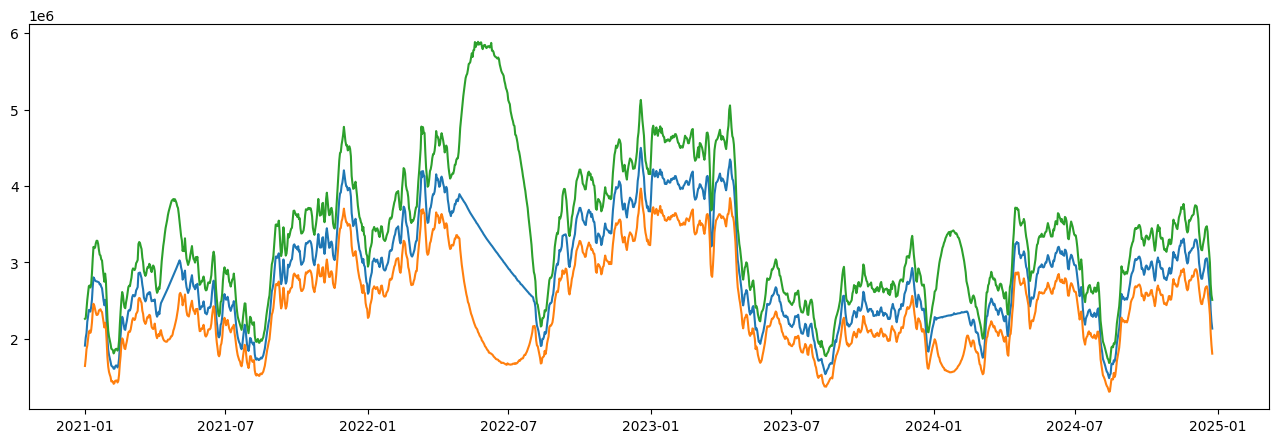

In [52]:
plt.figure(figsize=(16,5))

plt.plot(raw_data.dateStart.values, concat_NT_hat)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIL)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIU)

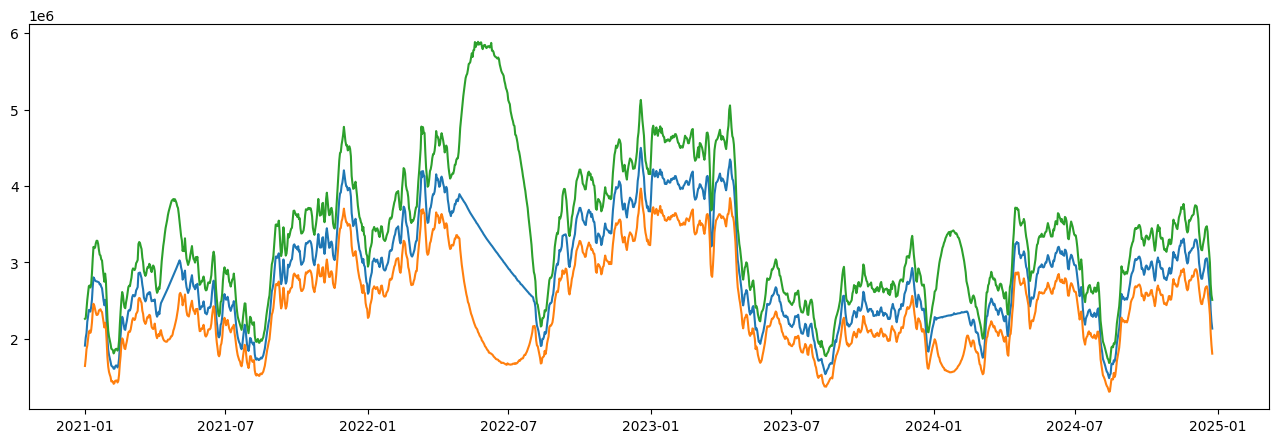

In [30]:
plt.figure(figsize=(16,5))

plt.plot(raw_data.dateStart.values, concat_NT_hat)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIL)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIU)

In [53]:
raw_data['Nt_hat_4'] = concat_NT_hat
raw_data['Nt_hat_4_CIL'] = concat_NT_hat_CIL
raw_data['Nt_hat_4_CIU'] = concat_NT_hat_CIU
raw_data.to_csv('../outputs/files/ww_estimator/df_' + wwtp + '_final.csv', index=False, sep=";")

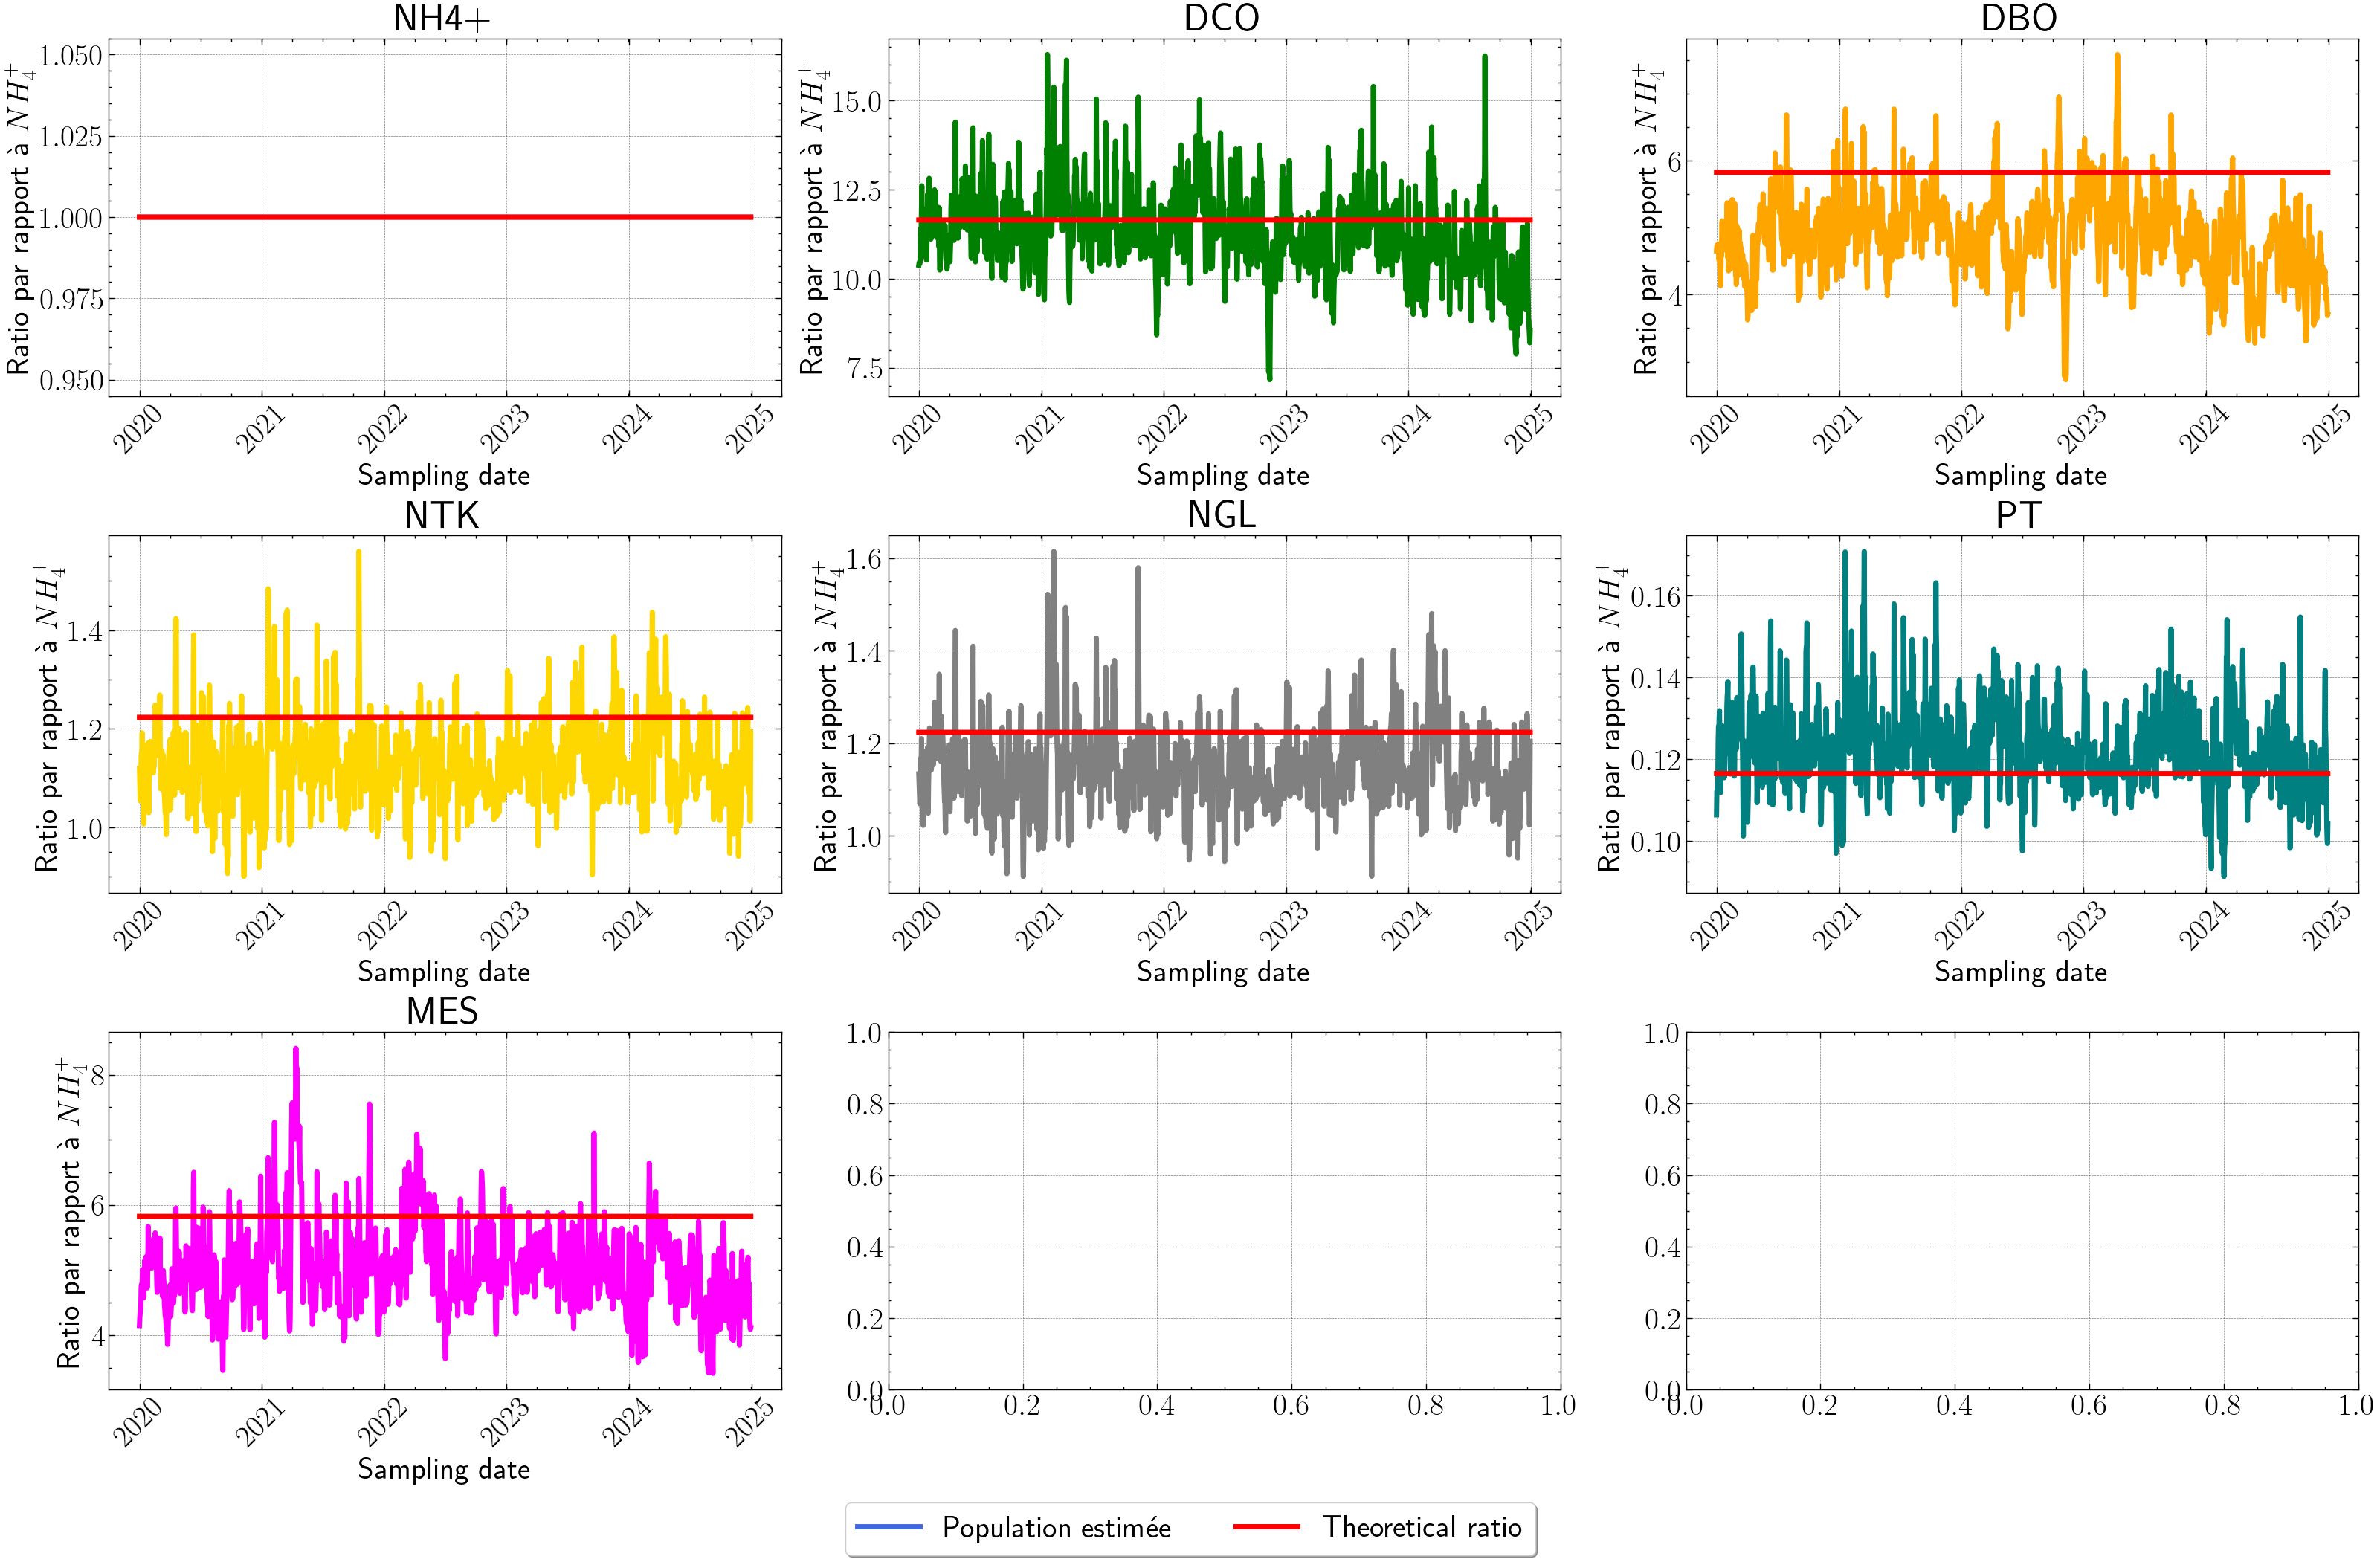

[  9.34793356 103.94572729  41.97226526  11.97632322  12.6
   1.19538407  45.47478244]
[ 11.06280825 124.52190484  53.68159731  12.42761914  12.6
   1.34719358  55.65214593]
[ 12.53262741 145.32173299  65.88808598  12.52030985  12.6
   1.52088684  72.02226604]
[ 11.15410589 128.15775896  53.93984364  12.37514038  12.6
   1.36484531  54.54832526]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.15410589 128.15775896  53.93984364  12.37514038  12.6
   1.36484531  54.54832526]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.15410589 128.15775896  53.93984364  12.37514038  12.6
   1.36484531  54.54832526]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 10.9011895  126.80765669  55.2408044   12.36240635  12.6
   1.35449715  57.1850601 ]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(365, 5) (5,)
---------
[ 10.9011895  126.80765669  55.2408044   12.36240635  1

In [39]:
wwtp = 'MAV'
raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU = get_obs_matrix(wwtp)
#raw_data = raw_data.loc[(raw_data.dateStart>='2021-01-01')&(raw_data.dateStart<='2024-12-31')]
#raw_data.reset_index(inplace=True, drop=True)

'NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES'
QIj_vect = np.array([10.3, 120, 60, 12.6, 12.6, 1.2, 60])

plot_indicators(raw_data, obs_matrix, QIj_vect)
get_new_QIj_vect_and_CIs(obs_matrix)

# let's start with 2021

k = 4
components = [0, 1, 2, 3, 4]

years = [2020, 2021, 2022, 2023, 2024]
NT_hat_list, NT_hat_CIL_list, NT_hat_CIU_list = [], [], []

for year in years:
    those_indexes = raw_data.loc[raw_data.year==year].index.tolist()

    this_NT_hat = model_3_estimation(obs_matrix[those_indexes], obs_matrix[those_indexes], k, components)
    this_NT_hat_CIL = model_3_estimation(obs_matrix[those_indexes], obs_matrix_CIL[those_indexes], k, components)
    this_NT_hat_CIU = model_3_estimation(obs_matrix[those_indexes], obs_matrix_CIU[those_indexes], k, components)

    NT_hat_list.append(this_NT_hat)
    NT_hat_CIL_list.append(this_NT_hat_CIL)
    NT_hat_CIU_list.append(this_NT_hat_CIU)

In [43]:
concat_NT_hat = np.array([])

for el in NT_hat_list:
    el = np.array(el)
    concat_NT_hat = np.hstack((concat_NT_hat, el))

concat_NT_hat_CIL = np.array([])

for el in NT_hat_CIL_list:
    el = np.array(el)
    concat_NT_hat_CIL = np.hstack((concat_NT_hat_CIL, el))

concat_NT_hat_CIU = np.array([])

for el in NT_hat_CIU_list:
    el = np.array(el)
    concat_NT_hat_CIU = np.hstack((concat_NT_hat_CIU, el))

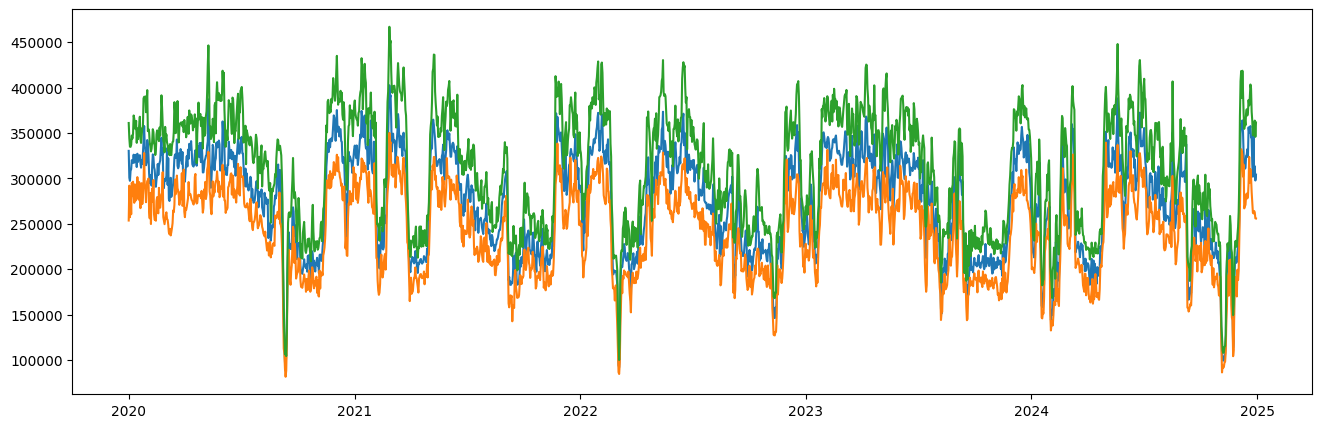

In [44]:
plt.figure(figsize=(16,5))

plt.plot(raw_data.dateStart.values, concat_NT_hat)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIL)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIU)

In [45]:
raw_data['Nt_hat_4'] = concat_NT_hat
raw_data['Nt_hat_4_CIL'] = concat_NT_hat_CIL
raw_data['Nt_hat_4_CIU'] = concat_NT_hat_CIU
raw_data.to_csv('../outputs/files/ww_estimator/df_' + wwtp + '_final_crAssPMMoV.csv', index=False, sep=";")

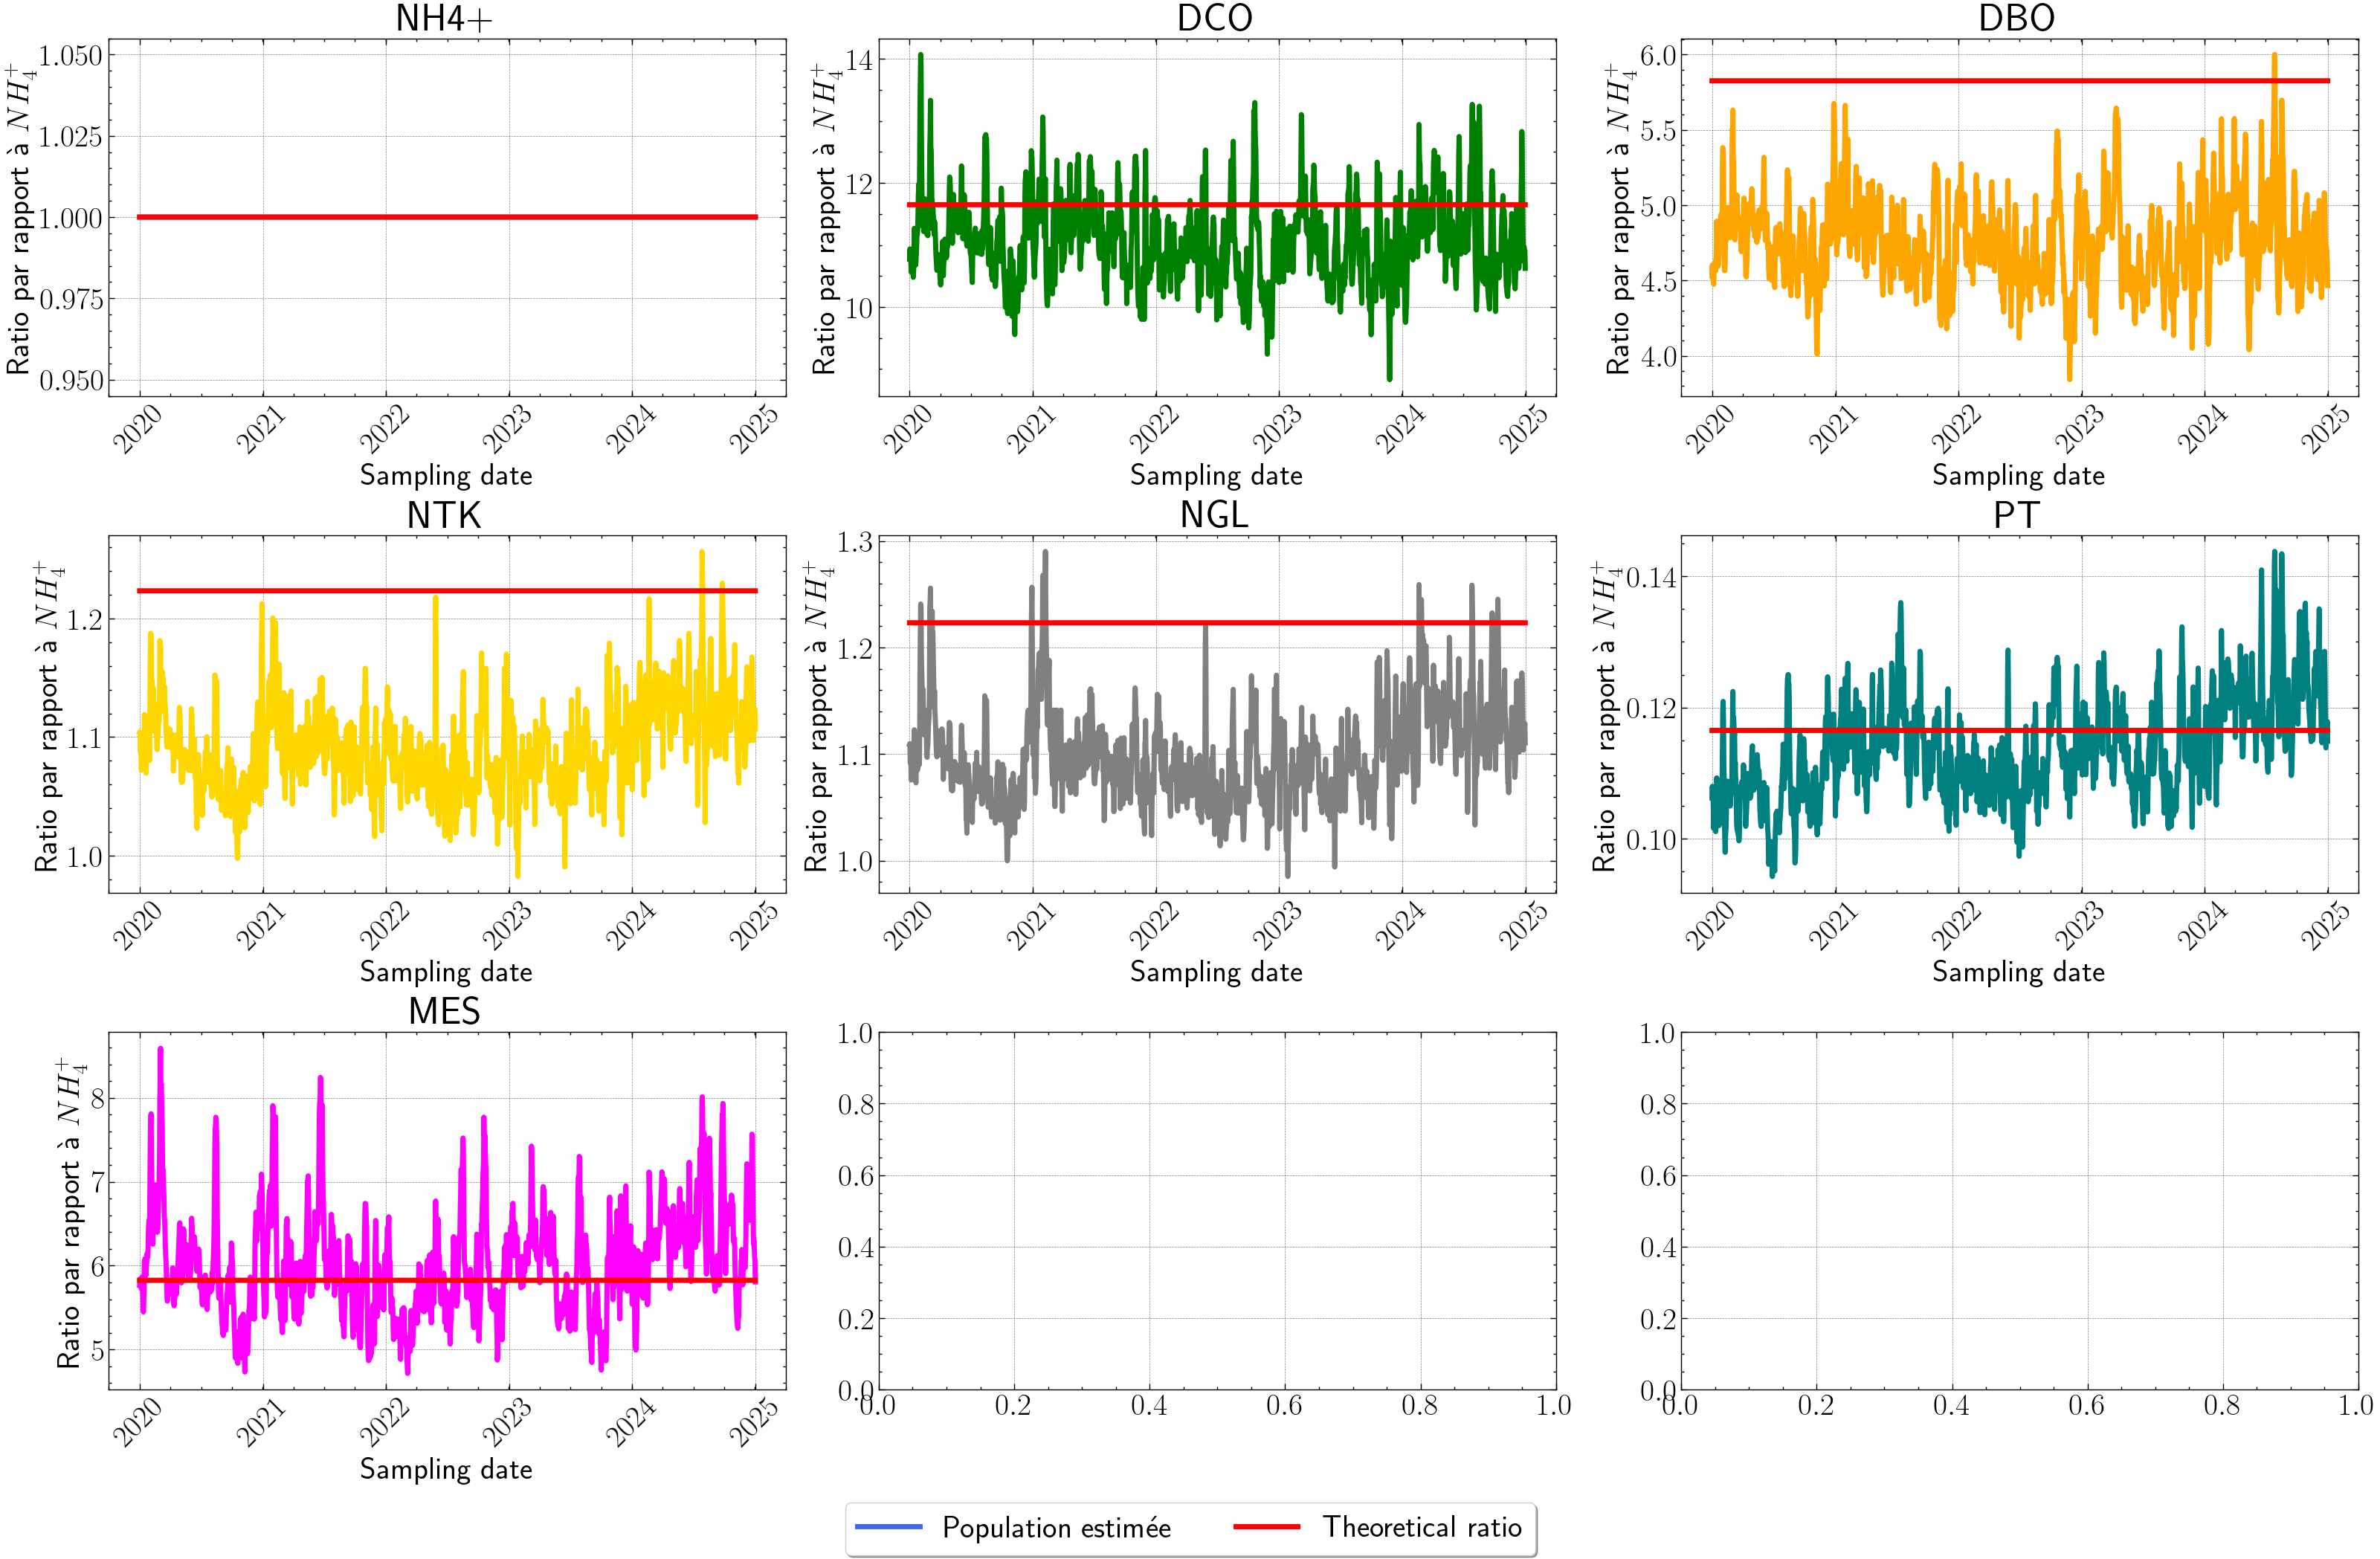

[ 10.44713473 115.64446941  49.75369938  12.02515922  12.6
   1.17553537  59.43282811]
[ 11.48858281 126.83481394  54.47919397  12.51497362  12.6
   1.30342301  68.85574814]
[ 12.19069635 138.86914882  59.38262517  12.58528959  12.6
   1.44068654  81.06239303]
[ 11.55521994 128.57250978  55.13338462  12.49602278  12.6
   1.24249963  69.07462434]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.55521994 128.57250978  55.13338462  12.49602278  12.6
   1.24249963  69.07462434]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.55521994 128.57250978  55.13338462  12.49602278  12.6
   1.24249963  69.07462434]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(366, 5) (5,)
---------
[ 11.44689863 127.70522595  54.35325233  12.50326805  12.6
   1.31225135  68.26617588]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(365, 5) (5,)
---------
[ 11.44689863 127.70522595  54.35325233  12.50326805  1

In [46]:
wwtp = 'SEV'
raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU = get_obs_matrix(wwtp)
#raw_data = raw_data.loc[(raw_data.dateStart>='2021-01-01')&(raw_data.dateStart<='2024-12-31')]
#raw_data.reset_index(inplace=True, drop=True)

'NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES'
QIj_vect = np.array([10.3, 120, 60, 12.6, 12.6, 1.2, 60])

plot_indicators(raw_data, obs_matrix, QIj_vect)
get_new_QIj_vect_and_CIs(obs_matrix)

# let's start with 2021

k = 4
components = [0, 1, 2, 3, 4]

years = [2020, 2021, 2022, 2023, 2024]
NT_hat_list, NT_hat_CIL_list, NT_hat_CIU_list = [], [], []

for year in years:
    those_indexes = raw_data.loc[raw_data.year==year].index.tolist()

    this_NT_hat = model_3_estimation(obs_matrix[those_indexes], obs_matrix[those_indexes], k, components)
    this_NT_hat_CIL = model_3_estimation(obs_matrix[those_indexes], obs_matrix_CIL[those_indexes], k, components)
    this_NT_hat_CIU = model_3_estimation(obs_matrix[those_indexes], obs_matrix_CIU[those_indexes], k, components)

    NT_hat_list.append(this_NT_hat)
    NT_hat_CIL_list.append(this_NT_hat_CIL)
    NT_hat_CIU_list.append(this_NT_hat_CIU)

In [47]:
concat_NT_hat = np.array([])

for el in NT_hat_list:
    el = np.array(el)
    concat_NT_hat = np.hstack((concat_NT_hat, el))

concat_NT_hat_CIL = np.array([])

for el in NT_hat_CIL_list:
    el = np.array(el)
    concat_NT_hat_CIL = np.hstack((concat_NT_hat_CIL, el))

concat_NT_hat_CIU = np.array([])

for el in NT_hat_CIU_list:
    el = np.array(el)
    concat_NT_hat_CIU = np.hstack((concat_NT_hat_CIU, el))

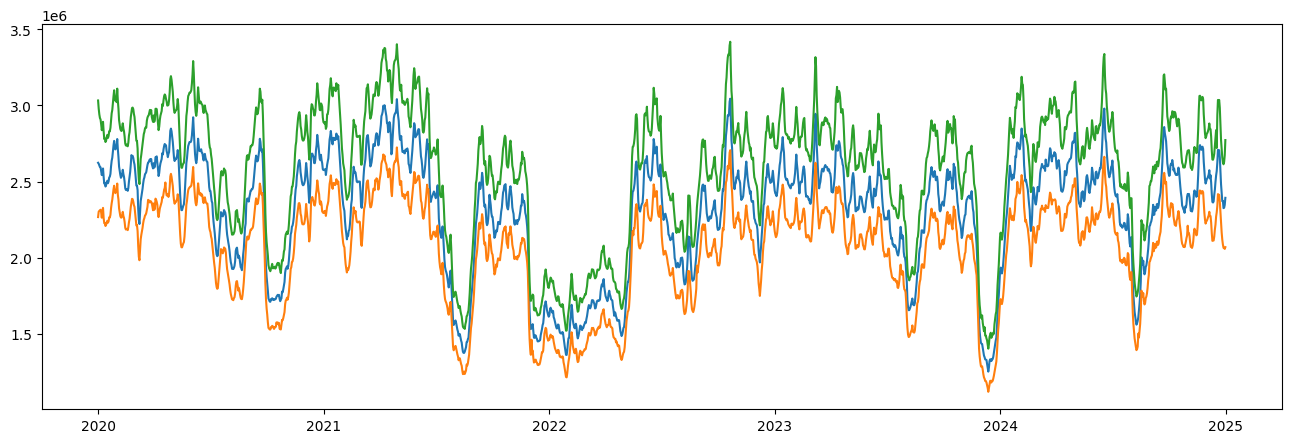

In [48]:
plt.figure(figsize=(16,5))

plt.plot(raw_data.dateStart.values, concat_NT_hat)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIL)
plt.plot(raw_data.dateStart.values, concat_NT_hat_CIU)

In [49]:
raw_data['Nt_hat_4'] = concat_NT_hat
raw_data['Nt_hat_4_CIL'] = concat_NT_hat_CIL
raw_data['Nt_hat_4_CIU'] = concat_NT_hat_CIU
raw_data.to_csv('../outputs/files/ww_estimator/df_' + wwtp + '_final_crAssPMMoV.csv', index=False, sep=";")